In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lazypredict.Supervised import LazyRegressor

In [32]:
train_df = pd.read_csv('C:/Users/Qann/OneDrive - Phenikaa Univesity/machine-learning/Data/FutureSale/sales_train.csv')
submission  = pd.read_csv('C:/Users/Qann/OneDrive - Phenikaa Univesity/machine-learning/Data/FutureSale/sample_submission.csv')
test_df = pd.read_csv('C:/Users/Qann/OneDrive - Phenikaa Univesity/machine-learning/Data/FutureSale/test.csv')

In [33]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,1709.05,1.00
4,15.01.2013,0,25,2555,1099.00,1.00


In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [35]:
train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24
std,9.42,16.23,6324.30,1729.80,2.62
min,0.00,0.00,0.00,-1.00,-22.00
25%,7.00,22.00,4476.00,249.00,1.00
50%,14.00,31.00,9343.00,399.00,1.00
75%,23.00,47.00,15684.00,999.00,1.00
max,33.00,59.00,22169.00,307980.00,2169.00


find null value 

In [36]:
train_df[train_df['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.00,1.00


In [37]:
train_df[train_df['item_cnt_day']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.00,-1.00
148,23.01.2013,0,25,2321,999.00,-1.00
175,07.01.2013,0,25,2199,1449.00,-1.00
807,02.01.2013,0,25,2330,599.00,-1.00
1041,13.01.2013,0,25,5034,1989.00,-1.00
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.00,-1.00
2934462,18.10.2015,33,25,4896,6398.00,-1.00
2935263,05.10.2015,33,25,10039,249.00,-1.00
2935643,16.10.2015,33,25,7893,2990.00,-1.00


remove null value

In [38]:
train_df = train_df[(train_df['item_price'] > 0) & (train_df['item_cnt_day'] > 0)]
print(train_df.shape)

(2928492, 6)


In [39]:
train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y')

visualize data

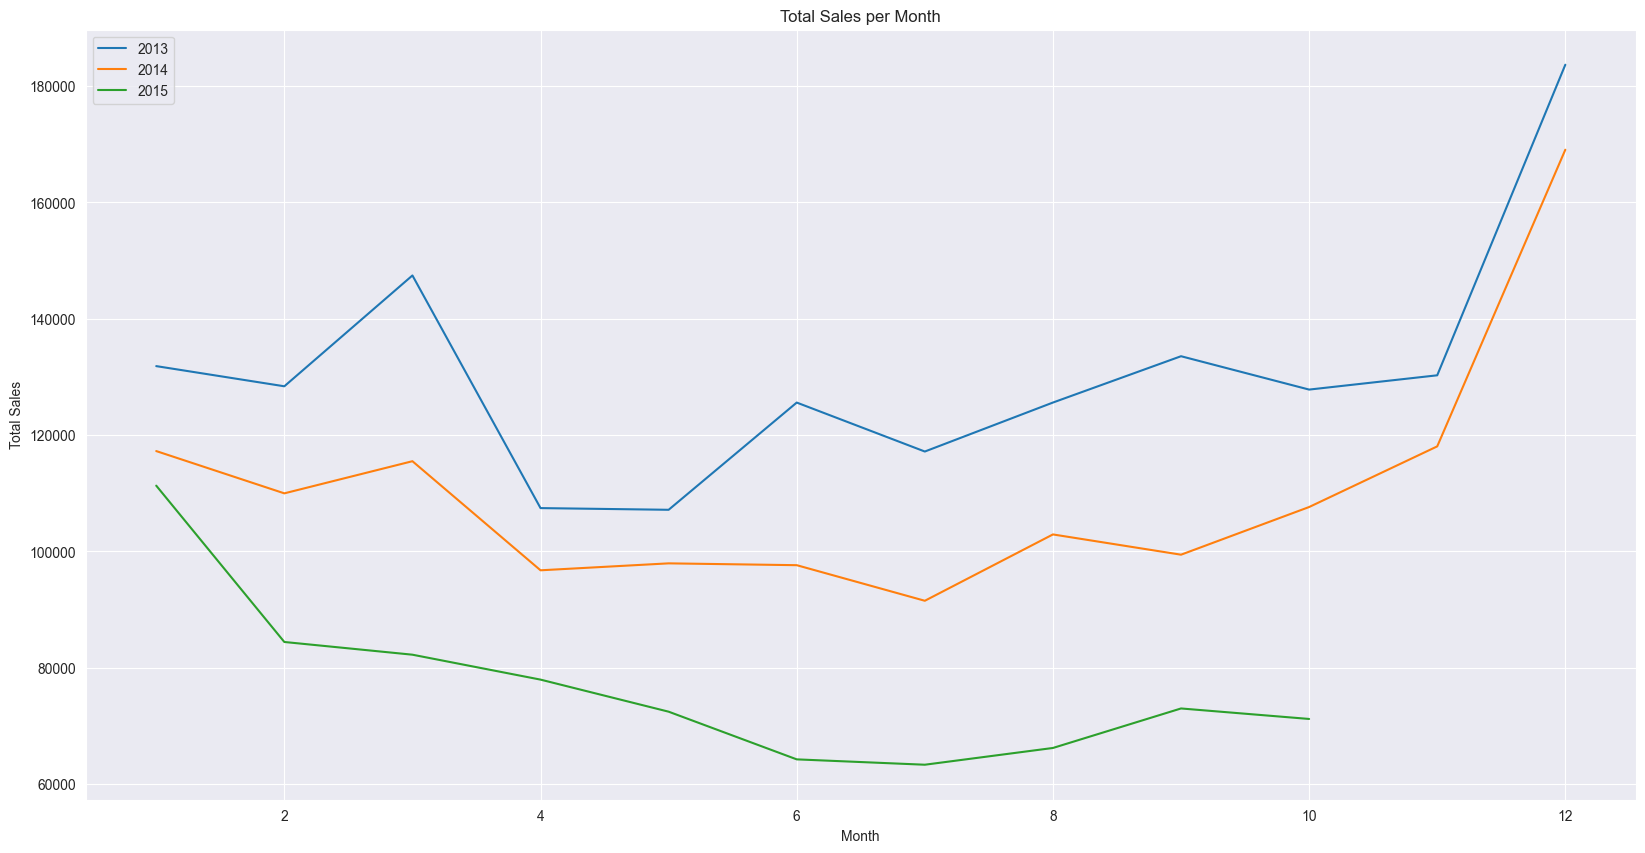

In [40]:
df_tmp = train_df.copy()

# add year and date col
df_tmp = df_tmp.rename(columns={"item_cnt_day": "item_cnt_month"})
df_tmp['year'] = df_tmp['date'].dt.year
df_tmp['month'] = df_tmp['date'].dt.month

# group data fllow moth and year
df_tmp = df_tmp.groupby(['year', 'month'])[['item_cnt_month']].sum().reset_index()

# split data
data_2013 = df_tmp[df_tmp['year'] == 2013]
data_2014 = df_tmp[df_tmp['year'] == 2014]
data_2015 = df_tmp[df_tmp['year'] == 2015]

plt.figure(figsize=(20, 10))

plt.plot(data_2013['month'], data_2013['item_cnt_month'], label='2013')
plt.plot(data_2014['month'], data_2014['item_cnt_month'], label='2014')
plt.plot(data_2015['month'], data_2015['item_cnt_month'], label='2015')

plt.title('Total Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


In the following years, the number of products sold tended to decrease.

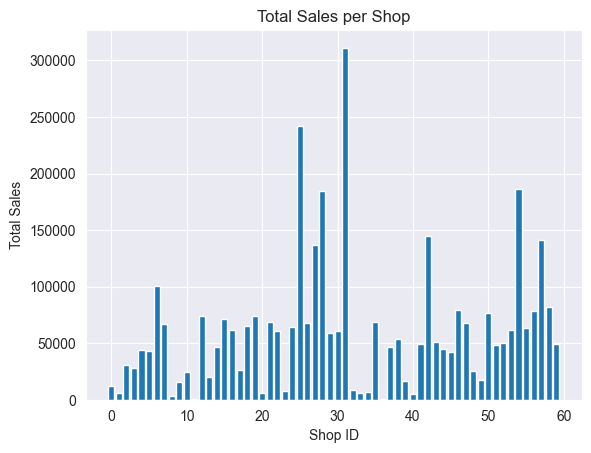

<Figure size 2000x1000 with 0 Axes>

In [41]:
df_shop = train_df.groupby('shop_id')['item_cnt_day'].sum().reset_index()
plt.bar(df_shop['shop_id'], df_shop['item_cnt_day'])
plt.title('Total Sales per Shop')
plt.xlabel('Shop ID')
plt.ylabel('Total Sales')
plt.figure(figsize=(20, 10))
plt.show()

Items with id around 30 are best sellers

In [42]:
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df['date_of_weak'] = train_df['date'].dt.dayofweek
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,date_of_weak
0,2013-01-02,0,59,22154,999.00,1.00,1,2013,2
1,2013-01-03,0,25,2552,899.00,1.00,1,2013,3
3,2013-01-06,0,25,2554,1709.05,1.00,1,2013,6
4,2013-01-15,0,25,2555,1099.00,1.00,1,2013,1
5,2013-01-10,0,25,2564,349.00,1.00,1,2013,3


In [43]:
monthly_sales = train_df.groupby(['date_block_num','shop_id','item_id']).agg(
    {
        "item_cnt_day":'sum',
        "item_price":'mean'
    }
).reset_index()
monthly_sales = monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month'})
monthly_sales.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,0,32,6.00,221.00
1,0,0,33,3.00,347.00
2,0,0,35,1.00,247.00
3,0,0,43,1.00,221.00
4,0,0,51,2.00,128.50


move down to be able to predict based on past data

In [44]:
def add_lags(df, lags, column):
    for lag in lags:
        df[f'{column}_lag_{lag}'] = df.groupby(['shop_id', 'item_id'])[column].shift(lag)
    return df
monthly_df = add_lags(monthly_sales, [1, 2, 3], 'item_cnt_month')
monthly_df.fillna(0, inplace=True)
monthly_df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.00,221.00,0.00,0.00,0.00
1,0,0,33,3.00,347.00,0.00,0.00,0.00
2,0,0,35,1.00,247.00,0.00,0.00,0.00
3,0,0,43,1.00,221.00,0.00,0.00,0.00
4,0,0,51,2.00,128.50,0.00,0.00,0.00


correlation

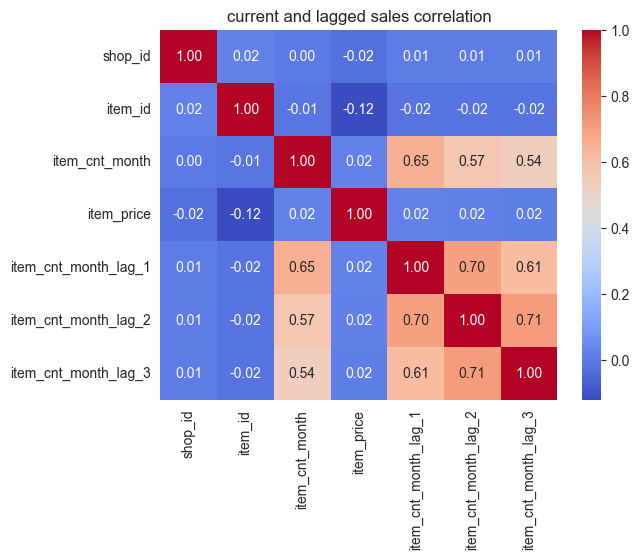

In [45]:
correlations = monthly_df.iloc[:,1:].corr()
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('current and lagged sales correlation')
plt.show()

In [46]:
monthly_df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.00,221.00,0.00,0.00,0.00
1,0,0,33,3.00,347.00,0.00,0.00,0.00
2,0,0,35,1.00,247.00,0.00,0.00,0.00
3,0,0,43,1.00,221.00,0.00,0.00,0.00
4,0,0,51,2.00,128.50,0.00,0.00,0.00


In [47]:
monthly_df['rolling_mean_3'] = monthly_df.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(window=3).mean())
monthly_df['rolling_std_3'] = monthly_df.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(window=3).std())
monthly_df.fillna(0, inplace=True)
monthly_df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,rolling_mean_3,rolling_std_3
0,0,0,32,6.00,221.00,0.00,0.00,0.00,0.00,0.00
1,0,0,33,3.00,347.00,0.00,0.00,0.00,0.00,0.00
2,0,0,35,1.00,247.00,0.00,0.00,0.00,0.00,0.00
3,0,0,43,1.00,221.00,0.00,0.00,0.00,0.00,0.00
4,0,0,51,2.00,128.50,0.00,0.00,0.00,0.00,0.00


In [48]:
x_train = monthly_df[monthly_df['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
y_train = monthly_df[monthly_df['date_block_num'] < 33]['item_cnt_month']
x_test = monthly_df[monthly_df['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
y_test = monthly_df[monthly_df['date_block_num'] == 33]['item_cnt_month']

In [49]:
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

MSE: 73.12159153479087
MAE: 1.0971995891135942


In [50]:
test_data = test_df.copy()
test_data['date_block_num'] = 34
test_data = test_data.merge(monthly_df, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
test_data.head()

,ID,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,rolling_mean_3,rolling_std_3
0,0,5,5037,34,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1,5,5320,34,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,5,5233,34,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3,5,5232,34,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4,5,5268,34,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [52]:
X_test = test_data[['date_block_num','shop_id','item_id','item_price','item_cnt_month_lag_1',
                    'item_cnt_month_lag_2','item_cnt_month_lag_3','rolling_mean_3','rolling_std_3']]
dtest = xgb.DMatrix(X_test)

test_data['item_cnt_month'] = model.predict(X_test).clip(0, 20).round()

In [53]:
result = pd.concat([test_df["ID"], test_data['item_cnt_month']], axis = 1)
result.to_csv('submission.csv',index_label='ID')